In [1]:
import math
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')
from torch import nn, optim
from torch.nn import functional as F
import torch
import torchvision
from laplace import Laplace
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 18,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

from src.weight_distribution.Full import FullCovariance
from src.weight_distribution.Diagonal import Diagonal
from src.network.Classification import LLVIClassification
from src.network import PredictApprox, LikApprox


In [2]:
class CNN(nn.Module):
    def __init__(self, out_dim=10, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, out_dim, bias=False)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        x = self.fc3(x)
        return x 


class VICNN(nn.Module):
    def __init__(self, feature_dim=50, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, feature_dim)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        return x

In [3]:
batch_size_train = 32
filepath = "/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/datasets/Classification"
dataset = torchvision.datasets.MNIST(filepath, train=True, download=False,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ]))
train_size = int(0.5 * len(dataset))
rest_size = len(dataset) - train_size                            
dataset, _ = torch.utils.data.random_split(dataset, [train_size, rest_size])
train_loader = torch.utils.data.DataLoader(dataset,
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

/opt/homebrew/Caskroom/miniforge/base/envs/DeepLearning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size_test = 6000
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
batch_size=batch_size_test, shuffle=True)

In [5]:
# general parameters
feature_dim = 50
out_dim=10
weight_decay = 1e-3
lr = 1e-3
base_train_epochs = 20
prior_log_var = math.log(1/(weight_decay * n_datapoints)) # set to wdecay

# VI parameters
tau = 1
vi_train_epochs = 50
train_samples = 1
test_samples=100

In [6]:
torch.manual_seed(3)
basemodel = CNN(weight_decay=weight_decay, lr=lr, out_dim=out_dim)
criterion = torch.nn.CrossEntropyLoss()

# train
pbar = tqdm(range(base_train_epochs))
for i in pbar:
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        basemodel.optimizer.zero_grad()
        output = basemodel(X_batch)
        output = F.log_softmax(output, dim=-1)
        loss = criterion(output, y_batch)
        loss.backward()
        epoch_loss += loss.item()
        basemodel.optimizer.step()

    pbar.set_description(f"Loss: {round(epoch_loss/len(train_loader), 2)}")

Loss: 0.12: 100%|██████████| 20/20 [02:05<00:00,  6.28s/it]


## LLVI estimation

In [7]:
dist_refined = Diagonal(feature_dim, out_dim, lr=lr)
dist_refined.update_mean(torch.t(basemodel.fc3.weight)) # we update the mean but keep the variance

vi_model_refined = VICNN(weight_decay=weight_decay, lr=lr, feature_dim=feature_dim)
with torch.no_grad():
    vi_model_refined.load_state_dict(basemodel.state_dict(), strict=False)

net_refined = LLVIClassification(feature_dim, out_dim, vi_model_refined, dist_refined, prior_log_var=prior_log_var, optimizer_type=torch.optim.Adam,
tau=tau, lr=lr)

for X_batch, y_batch in test_loader:
    predictions = net_refined(X_batch, method=PredictApprox.MONTECARLO, samples=test_samples)
    pred_test = torch.argmax(predictions, dim=1)
    print("Accuracy with VI before Training", torch.mean((pred_test == y_batch).float()).item())

net_refined_train_loss = net_refined.train_model(train_loader, epochs=vi_train_epochs, n_datapoints=n_datapoints, samples=train_samples, method=LikApprox.MONTECARLO)

for X_batch, y_batch in test_loader:
    predictions = net_refined(X_batch, method=PredictApprox.MONTECARLO, samples=test_samples)
    pred_test = torch.argmax(predictions, dim=1)
    print("Accuracy with VI after Training", torch.mean((pred_test == y_batch).float()).item())

Accuracy with VI before Training 0.9614999890327454
Accuracy with VI before Training 0.9545000195503235


prediction_loss:0.36 kl_loss:0.45: 100%|██████████| 50/50 [05:40<00:00,  6.81s/it]


Accuracy with VI after Training 0.9736666679382324
Accuracy with VI after Training 0.9775000214576721


## Laplace approximation and then VI estimation

In [8]:
# define laplace
laplace_model = CNN(weight_decay=weight_decay, lr=lr, out_dim=out_dim)
laplace_model.load_state_dict(basemodel.state_dict())
la = Laplace(laplace_model, "classification",
    subset_of_weights="last_layer", hessian_structure="diag",
    prior_precision=weight_decay) # prior precision is set to wdecay
la.fit(train_loader)
for X_batch, y_batch in test_loader:
    predictions = la(X_batch, link_approx='mc', n_samples=test_samples)
    pred_test = torch.argmax(predictions, dim=1)
    print("Accuracy with Laplace", torch.mean((pred_test == y_batch).float()).item())

Accuracy with Laplace 0.9703333377838135
Accuracy with Laplace 0.9712499976158142


In [9]:
dist_laplace_init = Diagonal(feature_dim, out_dim, lr=lr)
dist_laplace_init.update_var(torch.reshape(la.posterior_variance, (feature_dim, out_dim)))
dist_laplace_init.update_mean(torch.t(laplace_model.fc3.weight))

vi_model = VICNN(weight_decay=weight_decay, lr=lr, feature_dim=feature_dim)
with torch.no_grad():
    vi_model.load_state_dict(laplace_model.state_dict(), strict=False)

net_laplace_init = LLVIClassification(feature_dim, out_dim, vi_model, dist_laplace_init, prior_log_var=prior_log_var, optimizer_type=torch.optim.Adam,
tau=tau, lr=lr)

for X_batch, y_batch in test_loader:
    predictions = net_laplace_init(X_batch, method=PredictApprox.MONTECARLO, samples=test_samples)
    pred_test = torch.argmax(predictions, dim=1)
    print("Accuracy with VI before Training", torch.mean((pred_test == y_batch).float()).item())

net_laplace_train_loss = net_laplace_init.train_model(train_loader, epochs=vi_train_epochs, n_datapoints=n_datapoints, samples=train_samples, method=LikApprox.MONTECARLO)

for X_batch, y_batch in test_loader:
    predictions = net_laplace_init(X_batch, method=PredictApprox.MONTECARLO, samples=test_samples)
    pred_test = torch.argmax(predictions, dim=1)
    print("Accuracy with VI after Training", torch.mean((pred_test == y_batch).float()).item())

Accuracy with VI before Training 0.9695000052452087
Accuracy with VI before Training 0.9725000262260437


prediction_loss:0.11 kl_loss:0.07: 100%|██████████| 50/50 [05:48<00:00,  6.97s/it]


Accuracy with VI after Training 0.9769999980926514
Accuracy with VI after Training 0.9777500033378601


## Visualization

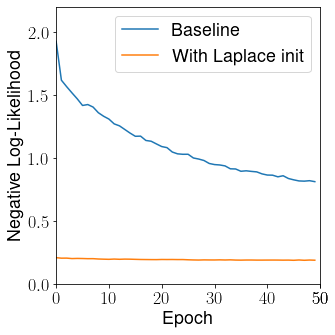

In [18]:
fig, axs = plt.subplots(figsize=(5,5))
x_values = list(range(vi_train_epochs))
axs.plot(x_values, net_refined_train_loss["prediction_loss"] + net_refined_train_loss["kl_loss"], label="Baseline")
axs.plot(x_values, net_laplace_train_loss["prediction_loss"] + net_laplace_train_loss["kl_loss"], label="With Laplace init")
axs.legend(loc = "upper right")
axs.set_xlabel("Epoch")
axs.set_ylabel("Negative Log-Likelihood")
axs.set_xlim(0, 50)
axs.set_xticks(list(axs.get_xticks()) + [50])
axs.set_ylim(0, 2.2)
fig.tight_layout()
plt.savefig("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/presentations/presentation_11_1/images/Classification/LaplaceInit")

## Evaluation

In [11]:
ood_test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                torchvision.transforms.RandomHorizontalFlip(p=1)
                            ])),
batch_size=batch_size_test, shuffle=True)

In [12]:
def test_confidence(predict_fun, test_loader, ood_test_loader):
    confidence_batch = []
    with torch.no_grad():
        for data, target in test_loader:
            output = predict_fun(data)
            pred, _ = torch.max(output, dim=1) # confidence in choice
            confidence_batch.append(torch.mean(pred))
        print(f"The mean confidence for in distribution data is: {sum(confidence_batch)/len(confidence_batch)}")

    ood_confidence_batch = []
    with torch.no_grad():
        for data, target in ood_test_loader:
            output = predict_fun(data)
            pred, _ = torch.max(output, dim=1) # confidence in choice
            ood_confidence_batch.append(torch.mean(pred))
        print(f"The mean confidence for out-of distribution data is: {sum(ood_confidence_batch)/len(ood_confidence_batch)}")

In [13]:
predict_samples = 100
la_predict_fun = lambda x: la(x, link_approx='mc', n_samples=predict_samples)
vi_laplace_init_predict_fun = lambda x: net_laplace_init(x, method=PredictApprox.MONTECARLO, samples=100)
vi_refined_predict_fun = lambda x: net_refined(x, method=PredictApprox.MONTECARLO, samples=100)

In [14]:
test_confidence(la_predict_fun, test_loader, ood_test_loader)

The mean confidence for in distribution data is: 0.9277576208114624
The mean confidence for out-of distribution data is: 0.7055772542953491


In [15]:
test_confidence(vi_laplace_init_predict_fun, test_loader, ood_test_loader)

The mean confidence for in distribution data is: 0.9428870677947998
The mean confidence for out-of distribution data is: 0.7388875484466553


In [16]:
test_confidence(vi_refined_predict_fun, test_loader, ood_test_loader)

The mean confidence for in distribution data is: 0.7291438579559326
The mean confidence for out-of distribution data is: 0.5143829584121704
